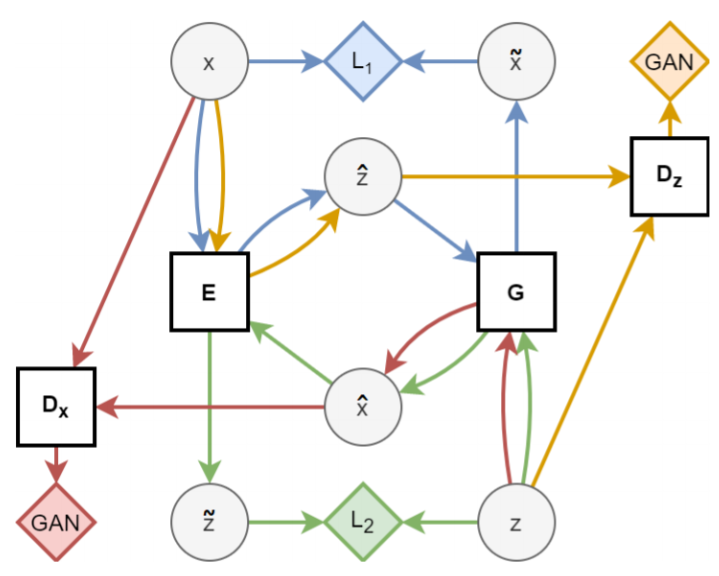

In [1]:
gpu_info = !nvidia-smi
gpu_info = gpu_info[:10]
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Wed Mar 10 16:36:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN V             On   | 00000000:17:00.0 Off |                  N/A |
| 28%   41C    P8    26W / 250W |      0MiB / 12066MiB |      0%      Default |


In [2]:
from varname import nameof
from collections import defaultdict
import sys
import torch
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim

from tqdm.notebook import tqdm_notebook as tq

from torch.autograd import Variable
from torchvision.transforms import transforms
from torchvision.utils import save_image, make_grid
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from pytorch_model_summary import summary
from tensorboardX import SummaryWriter

In [3]:
from src.dataset.utils import SavePath
from src.dataset.dataset import Cifar
from src.config import TrainConfig
from src.pytorch_msssim import MSSSIM, ssim

In [4]:
base_path = !pwd
base_path = base_path[0] + '/'

In [5]:
args = TrainConfig( base_path,              # project directory path
                    n_epochs = 200,         # number of epochs to train (default: 100)
                    batch_size = 128,       # input batch size for training (default: 128)
                    lr = 1e-3,            # learning rate (default: 0.0001)
                    dim_h = 128,            # hidden dimension (default: 128)')
                    n_z = 128,                # hidden dimension of z (default: 8)
                    LAMBDA = 10,            # regularization coef term (default: 10)
                    sigma = 1,              # variance of hidden dimension (default: 1)
                    n_channel = 3,          # input channels (default: 1)
                    img_size = 32 )         # image size

In [6]:
def unfreeze_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def freeze_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False

In [7]:
def save_models(model_path, epoch_no, models):
    print("Saving models")
    for model_name, model in models.items():
        torch.save(model.state_dict(), model_path + model_name + "_" + "%d.pth" % epoch_no)

def save_values_to_tensorboard(writer, epoch_no, values_dict: dict):
    for name, val in values_dict.items():
        if type(val) == dict:
            writer.add_scalars(name, val, epoch_no)
        else:
            writer.add_scalar(name, val, epoch_no)

def save_images_to_tensorboard(writer, epoch_no, image, imname='im'):
    writer.add_image(imname +'_{}'.format(epoch_no), image, epoch_no)

In [8]:
sp = SavePath(args)

/home/pr/synth.data/Autoencoder/outs/Wed-Mar-10-16-36-06-2021/


In [9]:
transform = None # dont normalize

cdl = Cifar(args)
train_loader = cdl.get_data_loader(True, transform, [0,1,2,3,4])
test_loader = cdl.get_data_loader(False, transform, [0,1,2,3,4])

Files already downloaded and verified
Files already downloaded and verified


In [10]:
from src.models.model_cifar import Encoder as ConvEncoder
from src.models.model_cifar import Decoder as ConvDecoder
from src.models.model_cifar import GanDiscriminator

In [11]:
class ZDiscriminator(nn.Module):
    def __init__(self, args):
        super(ZDiscriminator, self).__init__()

        self.n_channel = args.n_channel
        self.dim_h = args.dim_h
        self.n_z = args.n_z

        self.main = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 2),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 2, self.dim_h // 2),
            nn.ReLU(True),
            nn.Linear(self.dim_h // 2, self.dim_h // 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h // 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
#         x = x.squeeze()
        return x

In [12]:
E, G = ConvEncoder(args).cuda(), ConvDecoder(args).cuda()
D_x = GanDiscriminator(args).cuda()
D_z = ZDiscriminator(args).cuda()

mse_loss_fn = nn.MSELoss().cuda()
mae_loss_fn = nn.L1Loss().cuda()
adversarial_loss_fn = nn.BCELoss().cuda()

opt_AE = optim.Adam(list(E.parameters()) + list(G.parameters()), lr = args.lr)
opt_G = optim.Adam(G.parameters(), lr = 0.2 * args.lr)
opt_D_x = optim.Adam(D_x.parameters(), lr = 0.5 * args.lr)
opt_D_z = optim.Adam(D_z.parameters(), lr = 0.5 * args.lr)
# scheduler_opt_encoder = ExponentialLR(opt_encoder, gamma=0.01)
# scheduler_opt_decoder = ExponentialLR(opt_decoder, gamma=0.01)
# scheduler_opt_discriminator = ExponentialLR(opt_discriminator, gamma=0.01)
# scheduler_opt_zdiscriminator = ExponentialLR(opt_zdiscriminator, gamma=0.01)

In [13]:
# print(summary(conv_encoder, torch.zeros((1, 3, 32, 32)).cuda(), show_input=True, show_hierarchical=False))

In [14]:
def load_models(checkpoint_path, checkpoint):
    lp = SavePath(args, checkpoint_path)
    _, _, model_load_path = lp.get_save_paths()
    conv_encoder.load_state_dict(torch.load(model_load_path + "/conv_encoder_{}.pth".format(checkpoint)))
    conv_decoder.load_state_dict(torch.load(model_load_path + "/conv_decoder_{}.pth".format(checkpoint)))
    gan_discriminator.load_state_dict(torch.load(model_load_path + "/gan_discriminator_{}.pth".format(checkpoint)))

In [15]:
checkpoint = 0
if checkpoint:
    load_models('/home/pr/synth.data/Autoencoder/outs/Mon-Mar--1-12-35-57-2021/', checkpoint)

running_losses = defaultdict(list)
running_norms = defaultdict(list)

writer = SummaryWriter(log_dir = sp.results_path + "logs")

In [16]:
image_path, list_path, model_path = sp.get_save_paths()

In [17]:
# one = torch.tensor(1)
# mone = one * -1
# if torch.cuda.is_available():
#     one, mone = one.cuda(), mone.cuda()

In [ ]:
for epoch in range(checkpoint, checkpoint+args.n_epochs):
    pbar = tq(enumerate(train_loader))
    for step, (images, _) in pbar:
        
        current_batch_size = images.size()[0]        
        x = images.cuda()

        E.zero_grad()
        G.zero_grad()
        D_z.zero_grad()
        D_x.zero_grad()
        
        # Adversarial ground truths
        ones = Variable(torch.cuda.FloatTensor(current_batch_size, 1).fill_(1.0), requires_grad=False) # real
        zeros = Variable(torch.cuda.FloatTensor(current_batch_size, 1).fill_(0.0), requires_grad=False) # fake

        # ======== Train Discriminator ======== #

        unfreeze_params(D_z)
        unfreeze_params(D_x)

        z = torch.randn(current_batch_size, args.n_z).cuda()
        d_z = D_z(z)
        z_cap = E(x)
        d_z_cap = D_z(z_cap.detach())
        d_z_loss = adversarial_loss_fn(d_z, ones).mean() + adversarial_loss_fn(d_z_cap, zeros).mean()
        d_z_loss.backward()
        opt_D_z.step()
        
        d_x = D_x(x)
        x_cap = G(z)
        d_x_cap = D_x(x_cap.detach())
        
        d_x_loss = adversarial_loss_fn(d_x, ones).mean() + adversarial_loss_fn(d_x_cap, zeros).mean()
        d_x_loss.backward()
        opt_D_x.step()
        
        # ======== Train Generator ======== #

        freeze_params(D_x)
        freeze_params(D_z)
        
        z_cap = E(x)
        x_tilde = G(z_cap)
        d_z_cap = D_z(z_cap)       
        x_ae_loss = 10 * mae_loss_fn(x_tilde, x)
        z_disc_loss = adversarial_loss_fn(d_z_cap, ones)       
        x_loss = x_ae_loss + z_disc_loss      
        x_loss.backward()      
        opt_AE.step()
        
        x_cap = G(z)
        z_tilde = E(x_cap)
        d_x_cap = D_x(x_cap)      
        z_ae_loss = 5 * mse_loss_fn(z_tilde, z)
        x_disc_loss = adversarial_loss_fn(d_x_cap, ones)      
        z_loss = z_ae_loss + x_disc_loss     
        z_loss.backward()      
        opt_AE.step()
        
        running_losses["x_ae_loss"].append(x_ae_loss.mean().item())
        running_losses["z_ae_loss"].append(z_ae_loss.mean().item())
        running_losses["x_disc_loss"].append(x_disc_loss.mean().item())
        running_losses["z_disc_loss"].append(z_disc_loss.mean().item())

        running_norms["z_cap"].append([torch.norm(z_cap, dim=1).mean().item()])
        running_norms["z_tilde"].append([torch.norm(z_tilde, dim=1).mean().item()])
        running_norms["z"].append([torch.norm(z, dim=1).mean().item()])
        
        s = 'Losses:'
        for k, v in running_losses.items():
            s += '\t' + k + ': ' + str(round(v[-1], 3)) 
        pbar.set_description(s)

    if (epoch + 1) % 1 == 0:
        s = 'Losses:'
        for k, v in running_losses.items():
            running_losses[k] = np.mean(v, axis=0).round(3).item()
            s += '\t' + k + ': ' + str(np.mean(v, axis=0).round(3).item())
        s += '\nNorms:'
        for k, v in running_norms.items():
            running_norms[k] = np.mean(v, axis=0).round(3).item()
            s += '\t' + k + ': ' + str(np.mean(v, axis=0).round(3).item())
        print(s)
    
    if (epoch + 1) % 1 == 0:

        batch_size = 64
        test_iter = iter(test_loader)
        test_images, _ = next(test_iter)
        test_x = Variable(test_images)[:64]
        
        test_z_cap = E(test_x.cuda())
        test_x_tilde = G(test_z_cap)
        
        test_x_loss = mae_loss_fn(test_x, test_x_tilde.cpu()).mean().item()

        test_x_cap = G(torch.randn_like(test_z_cap)).cpu().view(batch_size, 3, 32, 32)

        test_image_recon = torch.cat((test_x.view(batch_size, 3, 32, 32), 
                                      test_x_tilde.cpu().view(batch_size, 3, 32, 32).data), axis=3)
        
        val_dict = {
        "train_losses": dict(running_losses),
        "test_recon_loss": test_x_loss,
        "norms": dict(running_norms)
        }
        
        save_values_to_tensorboard(writer, epoch + 1, val_dict)
        save_images_to_tensorboard(writer, epoch+1, make_grid(torch.cat((x, x_tilde), dim=3),
                                                                         normalize=False), 'train')
        save_images_to_tensorboard(writer, epoch+1, make_grid(test_image_recon, normalize=False), 'test')
        save_images_to_tensorboard(writer, epoch+1, make_grid(test_x_cap, normalize=False), 'sample')
        
        running_losses.clear()
        running_norms.clear()       
        

    if (epoch + 1) % 25 == 0:
        models = {nameof(E): E, nameof(G): G, nameof(D_x): D_x, nameof(D_z): D_z}
        save_models(model_path, epoch+1, models)

0it [00:00, ?it/s]

Losses:	x_ae_loss: 1.728	z_ae_loss: 5.275	x_disc_loss: 1.076	z_disc_loss: 1.055
Norms:	z_cap: 4.107	z_tilde: 2.651	z: 11.295


0it [00:00, ?it/s]

Losses:	x_ae_loss: 1.867	z_ae_loss: 5.29	x_disc_loss: 1.334	z_disc_loss: 2.832
Norms:	z_cap: 4.022	z_tilde: 2.226	z: 11.287


0it [00:00, ?it/s]

Losses:	x_ae_loss: 1.959	z_ae_loss: 5.625	x_disc_loss: 1.306	z_disc_loss: 4.391
Norms:	z_cap: 5.892	z_tilde: 3.413	z: 11.295


0it [00:00, ?it/s]

In [179]:
s

'Losses:\tx_ae_loss: 2.699\tz_ae_loss: 6.026\tx_disc_loss: 0.942\tz_disc_loss: 0.787\nNorms:\tz_cap: 4.401\tz_tilde: 4.065\tz: 11.285'

In [86]:
" ".join(["A", "B"])

'A B'

In [94]:
s = 'Losses:'
for k, v in d.items():
    s = ' '.join((s, ' '.join((k, str(round(v, 3))))))

In [95]:
s

'Losses: a 1 b 2 c 3'

In [ ]:
image = torch.cat((test_data[0].view(batch_size, 1, 28, 28), 
                                reconst.data), axis=3)

In [ ]:
image.shape

torch.Size([128, 1, 28, 56])

In [ ]:
np.mean(disc_loss, axis=0)

In [ ]:
disc_loss[0]

Output hidden; open in https://colab.research.google.com to view.

In [3]:
# encoder block (used in encoder and discriminator)
class EncoderBlock(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(EncoderBlock, self).__init__()
        # convolution to halve the dimensions
        self.conv = nn.Conv2d(in_channels=channel_in, out_channels=channel_out, kernel_size=5, padding=2, stride=2,
                              bias=False)
        self.bn = nn.BatchNorm2d(num_features=channel_out, momentum=0.9)

    def forward(self, ten, out=False,t = False):
        # here we want to be able to take an intermediate output for reconstruction error
        if out:
            ten = self.conv(ten)
            ten_out = ten
            ten = self.bn(ten)
            ten = F.relu(ten, False)
            return ten, ten_out
        else:
            ten = self.conv(ten)
            ten = self.bn(ten)
            ten = F.relu(ten, True)
            return ten


# decoder block (used in the decoder)
class DecoderBlock(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(DecoderBlock, self).__init__()
        # transpose convolution to double the dimensions
        self.conv = nn.ConvTranspose2d(channel_in, channel_out, kernel_size=5, padding=2, stride=2, output_padding=1,
                                       bias=False)
        self.bn = nn.BatchNorm2d(channel_out, momentum=0.9)

    def forward(self, ten):
        ten = self.conv(ten)
        ten = self.bn(ten)
        ten = F.relu(ten, True)
        return ten


class Encoder(nn.Module):
    def __init__(self, channel_in=3, z_size=128):
        super(Encoder, self).__init__()
        self.size = channel_in
        layers_list = []
        # the first time 3->64, for every other double the channel size
        for i in range(3):
            if i == 0:
                layers_list.append(EncoderBlock(channel_in=self.size, channel_out=64))
                self.size = 64
            else:
                layers_list.append(EncoderBlock(channel_in=self.size, channel_out=self.size * 2))
                self.size *= 2

        # final shape Bx256x8x8
        self.conv = nn.Sequential(*layers_list)
        self.fc = nn.Sequential(nn.Linear(in_features=8 * 8 * self.size, out_features=1024, bias=False),
                                nn.BatchNorm1d(num_features=1024,momentum=0.9),
                                nn.ReLU(True))
        # two linear to get the mu vector and the diagonal of the log_variance
        self.l_mu = nn.Linear(in_features=1024, out_features=z_size)
        self.l_var = nn.Linear(in_features=1024, out_features=z_size)

    def forward(self, ten):
        ten = self.conv(ten)
        ten = ten.view(len(ten), -1)
        ten = self.fc(ten)
        mu = self.l_mu(ten)
        logvar = self.l_var(ten)
        return mu, logvar

    def __call__(self, *args, **kwargs):
        return super(Encoder, self).__call__(*args, **kwargs)


class Decoder(nn.Module):
    def __init__(self, z_size, size):
        super(Decoder, self).__init__()
        # start from B*z_size
        self.fc = nn.Sequential(nn.Linear(in_features=z_size, out_features=8 * 8 * size, bias=False),
                                nn.BatchNorm1d(num_features=8 * 8 * size,momentum=0.9),
                                nn.ReLU(True))
        self.size = size
        layers_list = []
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size))
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//2))
        self.size = self.size//2
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//4))
        self.size = self.size//4
        # final conv to get 3 channels and tanh layer
        layers_list.append(nn.Sequential(
            nn.Conv2d(in_channels=self.size, out_channels=3, kernel_size=5, stride=1, padding=2),
            nn.Tanh()
        ))

        self.conv = nn.Sequential(*layers_list)

    def forward(self, ten):

        ten = self.fc(ten)
        ten = ten.view(len(ten), -1, 8, 8)
        ten = self.conv(ten)
        return ten

    def __call__(self, *args, **kwargs):
        return super(Decoder, self).__call__(*args, **kwargs)


class Discriminator(nn.Module):
    def __init__(self, channel_in=3,recon_level=3):
        super(Discriminator, self).__init__()
        self.size = channel_in
        self.recon_levl = recon_level
        # module list because we need need to extract an intermediate output
        self.conv = nn.ModuleList()
        self.conv.append(nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True)))
        self.size = 32
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=128))
        self.size = 128
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=256))
        self.size = 256
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=256))
        # final fc to get the score (real or fake)
        self.fc = nn.Sequential(
            nn.Linear(in_features=8 * 8 * self.size, out_features=512, bias=False),
            nn.BatchNorm1d(num_features=512,momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=1),
        )

    def forward(self, ten_orig, ten_predicted, ten_sampled, mode='REC'):
        if mode == "REC":
            ten = torch.cat((ten_orig, ten_predicted, ten_sampled), 0)
            for i, lay in enumerate(self.conv):
                # we take the 9th layer as one of the outputs
                if i == self.recon_levl:
                    ten, layer_ten = lay(ten, True)
                    # we need the layer representations just for the original and reconstructed,
                    # flatten, because it's a convolutional shape
                    layer_ten = layer_ten.view(len(layer_ten), -1)
                    return layer_ten
                else:
                    ten = lay(ten)
        else:
            ten = torch.cat((ten_orig, ten_predicted, ten_sampled), 0)
            for i, lay in enumerate(self.conv):
                    ten = lay(ten)

            ten = ten.view(len(ten), -1)
            ten = self.fc(ten)
            return F.sigmoid(ten)


    def __call__(self, *args, **kwargs):
        return super(Discriminator, self).__call__(*args, **kwargs)

In [4]:
disc = Discriminator()

In [ ]:
# print(summary(conv_encoder, torch.zeros((1, 3, 32, 32)).cuda(), show_input=False, show_hierarchical=False))
# print(summary(conv_decoder, torch.zeros((1, 1, 100)).cuda(), show_input=False, show_hierarchical=False))
print(summary(disc, torch.zeros((1, 1, 32, 32)).cuda(), show_input=False, show_hierarchical=False))